# Определение возраста покупателей

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей.  
Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Цель проекта**  
Построить модель, которая по фотографии определит приблизительный возраст человека. 


**План по выполнению проекта**
1. Провести исследовательский анализ набора фотографий.
2. Подготовить данные к обучению.
3. Обучить нейронную сеть и рассчитать её качество.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 100

labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [5]:
labels.shape

(7591, 2)

In [6]:
datagen = ImageDataGenerator(rescale=1./255,
validation_split=0.25)

train_generator = datagen.flow_from_dataframe(
dataframe=labels,
directory='/datasets/faces/final_files/',
x_col='file_name',
y_col='real_age',
target_size=(IMAGE_SIZE, IMAGE_SIZE),
batch_size=BATCH_SIZE,
class_mode='raw',
subset='training',
seed=12345)

val_generator = datagen.flow_from_dataframe(
dataframe=labels,
directory='/datasets/faces/final_files/',
x_col='file_name',
y_col='real_age',
target_size=(IMAGE_SIZE, IMAGE_SIZE),
batch_size=BATCH_SIZE,
class_mode='raw',
subset='validation',
seed=12345)

features_train, target_train = next(train_generator)
features_valid, target_valid = next(val_generator)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


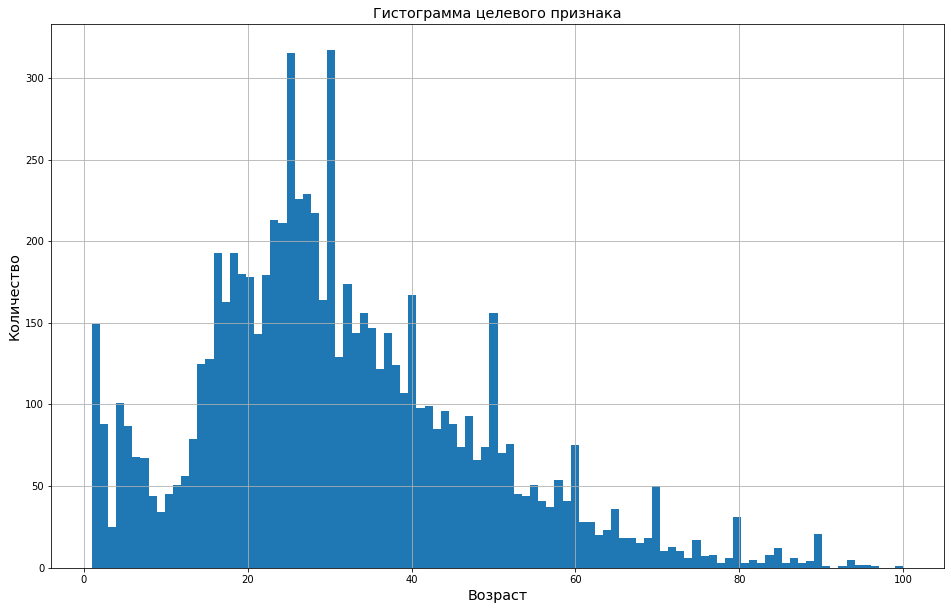

In [7]:
plt.figure(figsize=(16,10))
labels['real_age'].plot.hist(bins=100, grid=True)
plt.title('Гистограмма целевого признака', fontsize='x-large')
plt.xlabel('Возраст', fontsize='x-large')
plt.ylabel('Количество', fontsize='x-large')
plt.show()

<AxesSubplot:xlabel='real_age'>

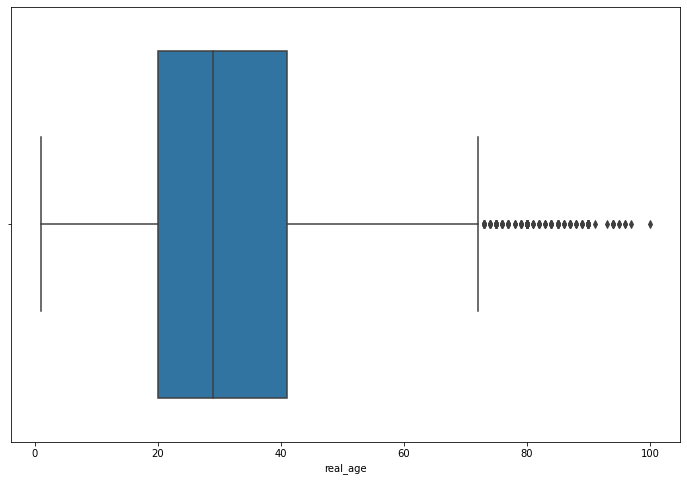

In [8]:
plt.figure(figsize=(12,8))
sns.boxplot(labels['real_age'])

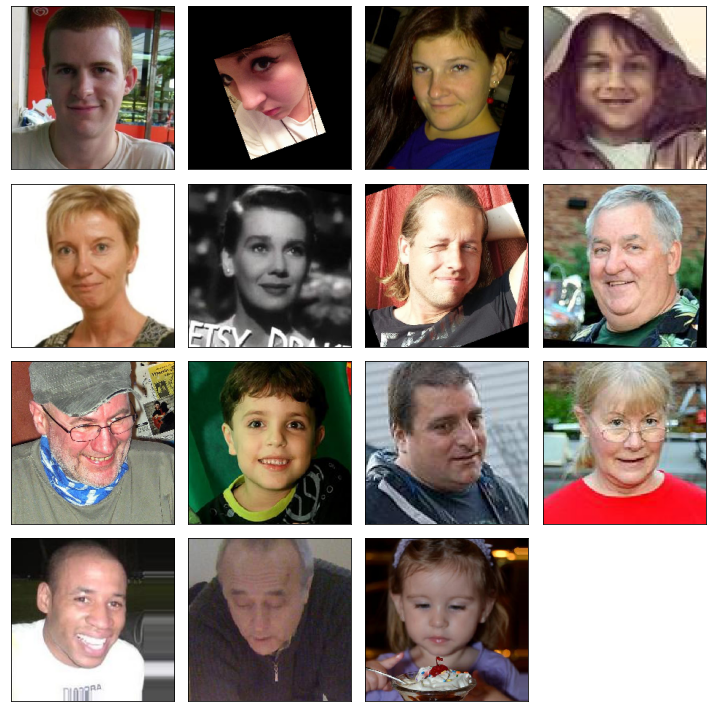

In [9]:
# выводим 10 изображений
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features_train[i])
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## Обучение модели

```python

def load_train(path):
    labels = pd.read_csv(path+'labels.csv')   

    datagen = ImageDataGenerator(rescale=1./255,  validation_split=0.25, 
                                 horizontal_flip=True)

    train_generator = datagen.flow_from_dataframe(
        labels,
        x_col="file_name", 
        y_col="real_age",
        directory = path + 'final_files/',
        target_size=(224, 224), 
        batch_size=16,  
        class_mode='raw', 
        subset='training', 
        seed=12345)
    
    return train_generator

def load_test(path):
    labels = pd.read_csv(path+'labels.csv') 

    datagen = ImageDataGenerator(rescale=1./255,  validation_split=0.25)

    test_generator = datagen.flow_from_dataframe(
        labels,
        x_col="file_name", 
        y_col="real_age",
        directory = path + 'final_files/',
        target_size=(224, 224), 
        batch_size=16,  
        class_mode='raw', 
        subset='validation', 
        seed=12345)
    
    return test_generator



def create_model(input_shape=(224, 224, 3)):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False) 
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))  
    optimizer = Adam(lr=0.00001)
    model.compile(optimizer=optimizer, loss='mean_absolute_error', 
              metrics=['mean_absolute_error'])

    return model 

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):
  
    
    model.fit(train_data,
              validation_data = test_data,
              epochs=epochs,
              batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, 
              shuffle=True
              )

    return model 

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/5
2022-12-19 08:27:11.967253: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-12-19 08:27:14.082851: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 69s - loss: 17.2855 - mean_absolute_error: 17.2881 - val_loss: 27.1004 - val_mean_absolute_error: 27.1053
Epoch 2/5
356/356 - 38s - loss: 8.3791 - mean_absolute_error: 8.3794 - val_loss: 10.2023 - val_mean_absolute_error: 10.1917
Epoch 3/5
356/356 - 38s - loss: 6.8341 - mean_absolute_error: 6.8348 - val_loss: 6.9956 - val_mean_absolute_error: 6.9957
Epoch 4/5
356/356 - 38s - loss: 6.0640 - mean_absolute_error: 6.0647 - val_loss: 7.0830 - val_mean_absolute_error: 7.0840
Epoch 5/5
356/356 - 38s - loss: 5.5296 - mean_absolute_error: 5.5299 - val_loss: 6.7894 - val_mean_absolute_error: 6.7962
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 6.7894 - mean_absolute_error: 6.7962
Test MAE: 6.7962

```

## Анализ обученной модели

1. Данные извлечены методом ImageDataGenerator.
2. Диаграмма разброса показывает, что большинство фотографий людей возрастом от 20 до 40. Есть выбросы, это может отразиться на обучении модели.
3. В датасете представлены разные фотографии (цветные и черно-белые).
4. Модель обучена в GPU-тренажёре. Метрика МАЕ составила 6.7962, т.е. модель предсказывает возрвст с ошибкой почти в 7 лет.